In [1]:
from mltoolbox.basic import *

In [2]:
import pyarrow.parquet as pq
from pathlib import Path

In [3]:
PATH = Path('data/')

In [4]:
list(PATH.iterdir())

[PosixPath('data/metadata_train.csv'),
 PosixPath('data/train.parquet'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/metadata_test.csv'),
 PosixPath('data/test.parquet')]

In [5]:
train = pq.read_pandas(PATH/'train.parquet').to_pandas()

In [6]:
train.shape

(800000, 8712)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 8712 entries, 0 to 8711
dtypes: int8(8712)
memory usage: 6.5 GB


metadata_[train/test].csv

`id_measurement:` the ID code for a trio of signals recorded at the same time.  
`signal_id     :` the foreign key for the signal data. Each signal ID is unique across both train and test, so the first ID in train is '0' but the first ID in test is '8712'.  
`phase         :` the phase ID code within the signal trio. **The phases may or may not all be impacted by a fault on the line.**  
`target        :` 0 if the power line is undamaged, 1 if there is a fault.

In [8]:
!head data/metadata_train.csv

signal_id,id_measurement,phase,target
0,0,0,0
1,0,1,0
2,0,2,0
3,1,0,1
4,1,1,1
5,1,2,1
6,2,0,0
7,2,1,0
8,2,2,0


In [9]:
train_meta = pd.read_csv(PATH/'metadata_train.csv')
test_meta = pd.read_csv(PATH/'metadata_test.csv')

In [10]:
train_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [11]:
train_meta.target.value_counts()

0    8187
1     525
Name: target, dtype: int64

In [12]:
train_meta.groupby(by=['target', 'phase'])['signal_id'].count()

target  phase
0       0        2726
        1        2738
        2        2723
1       0         178
        1         166
        2         181
Name: signal_id, dtype: int64

In [13]:
train_meta[train_meta.target == 1].groupby(by=['id_measurement']
                                          )[['phase']].count().query('phase < 3').head()

,phase
id_measurement,
67,2
96,1
126,1
159,1
271,1


In [14]:
train_meta[train_meta.target == 1].groupby(by=['id_measurement']
                                          )[['phase']].count()['phase'].value_counts()

3    156
2     19
1     19
Name: phase, dtype: int64

In [15]:
x = train_meta[train_meta.target == 1].groupby(by=['id_measurement']
                                               )[['phase']].count().query('phase < 3'
                                                                          ).index
x

Int64Index([  67,   96,  126,  159,  271,  301,  443,  518,  601,  608,  620,
             706,  894,  944,  988, 1068, 1076, 1091, 1132, 1256, 1268, 1277,
            1304, 1420, 1537, 1561, 1668, 1704, 1884, 1899, 1994, 2328, 2623,
            2693, 2753, 2760, 2807, 2876],
           dtype='int64', name='id_measurement')

In [16]:
y = train_meta[train_meta.target == 0]['id_measurement'].unique()

np.array([idx for idx in x if idx in y])

array([  67,   96,  126,  159,  271,  301,  443,  518,  601,  608,  620,
        706,  894,  944,  988, 1068, 1076, 1091, 1132, 1256, 1268, 1277,
       1304, 1420, 1537, 1561, 1668, 1704, 1884, 1899, 1994, 2328, 2623,
       2693, 2753, 2760, 2807, 2876])

In [17]:
sum(train_meta.groupby(by=['id_measurement'])['signal_id'].count() < 3)

0

**Training contains phase wise fault data, ergo 1, 2 or 3 any number of phases can be faulty**

In [18]:
sum(test_meta.groupby(by=['id_measurement'])['signal_id'].count() < 3)

0

**!!! Good news - if a line is present in test all the 3 phases is present.**

In [19]:
import matplotlib.pyplot as plt

In [32]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]
plt.style.use('ggplot')

In [21]:
train_meta[train_meta.id_measurement == 96]

,signal_id,id_measurement,phase,target
288,288,96,0,0
289,289,96,1,0
290,290,96,2,1


In [22]:
good = train.iloc[:, 288].values
bad = train.iloc[:, 290].values

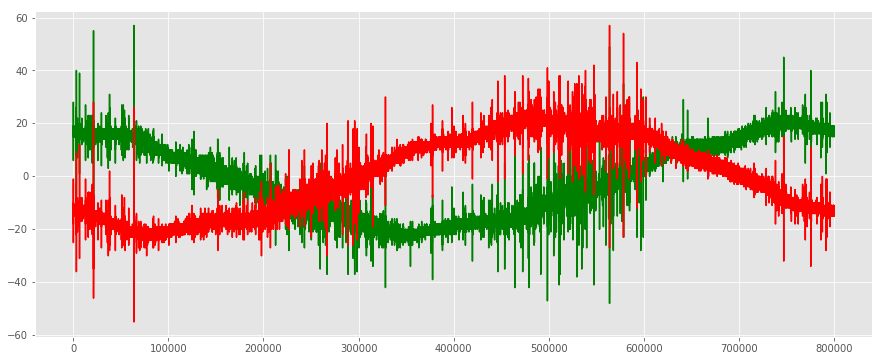

In [33]:
plt.plot(good, c='g')
plt.plot(bad, c='r')

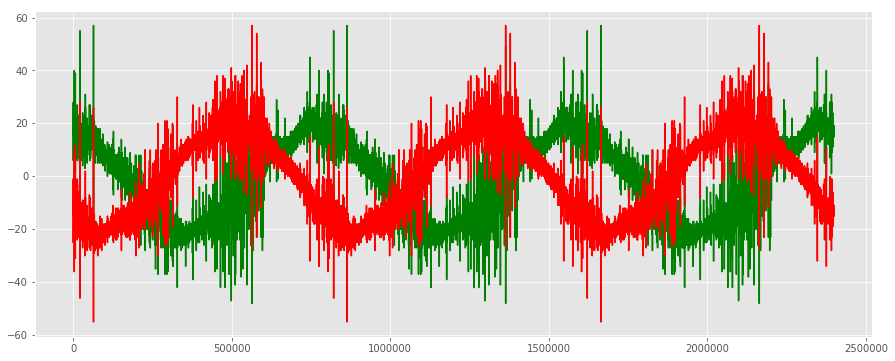

In [34]:
plt.plot(np.concatenate([good, good, good]), c='g')
plt.plot(np.concatenate([bad, bad, bad]), c='r')

## Metrics

In [1]:
from sklearn.metrics import matthews_corrcoef

In [6]:
y = [0, 1, 1, 0, 0, 1]
y_bar = [1, 0, 1, 0, 0, 1]

matthews_corrcoef(y_pred=y_bar, y_true=y)

0.3333333333333333

Ohhh very strict metric